# Mask R-CNN Instance Segmentation

In the previous notebooks, we performed object detection, where bounding boxes were used to indicate the objects contained in an image.  In this notebook, we will introduce [Mask R-CNN](https://arxiv.org/abs/1703.06870) for instance segmentation.  In other words, we will get the contours or masks of objects in an image besides bounding boxes.

## Image Segmentation

Image segmentation categorises pixels in an image into different groups in terms of some criteria, such as semantic segmentation and instance segmentation.  In this notebook, we are interested in instance segmentation which will not only detect the known objects in an image with bounding boxes, but also find which pixels belong to the objects using masks.

<img src="./media/segmentaion_comparison.png" width="1000"/>

## Mask R-CNN

[Mask R-CNN](https://arxiv.org/abs/1703.06870) is an instance segmentation alrogithm based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497) and adds an extra branch for predicting segmentation masks for objects (instances).  That is, the same feature map for training the RPN (Region Proposal Network) and classifier in Faster R-CNN is also used in Mask R-CNN by a FCN (Fully Convolutional Network) to predict a binary mask for the object inside a bounding box.

<img src="./media/mask-r-cnn-framework.png" width="600"/>

## Initialization

In [1]:
import sys

sys.path.append("../../")

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import scrapbook as sb
import torch
import torchvision

from utils_cv.common.data import data_path, unzip_url, get_files_in_directory
from utils_cv.common.gpu import is_windows, which_processor
from utils_cv.common.plot import show_ims
from utils_cv.detection.data import Urls, coco_labels
from utils_cv.detection.dataset import DetectionDataset, parse_pascal_voc_anno
from utils_cv.detection.mask import merge_binary_masks
from utils_cv.detection.model import DetectionLearner, get_pretrained_maskrcnn
from utils_cv.detection.plot import plot_detections, plot_pr_curves

# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend("TkAgg")

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.4.0
Cuda is not available. Torch is using CPU


In [2]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline


Next, set some model runtime parameters. We use the unzip_url helper function to download and unzip the data used in this example notebook.

In [3]:
DATA_PATH = unzip_url(Urls.fridge_objects_mask_path, exist_ok=True)
EPOCHS = 10
THRESHOLD = 0.5
IM_SIZE = 100 #500

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using torch device: {device}")

Using torch device: cpu


## Browse the Dataset

We are going to use the [odFridgeObjects-mask datasets](https://cvbp.blob.core.windows.net/public/datasets/object_detection/odFridgeObjectsMask.zip) for illustration.  The dataset has already downloaded and unzipped into `DATA_PATH`.  This dataset includes 31 images of 4 class labels: `can`, `carton`, `milk_bottle` and `water_bottle`.

```
odFridgeObjects-mask/
├── annotations
│   ├── 1.xml
│   ├── 2.xml
│   ├── ...
│   ├── 30.xml
│   └── 31.xml
├── images
│   ├── 1.jpg
│   ├── 2.jpg
│   ├── ...
│   ├── 30.jpg
│   └── 31.jpg
└── segmentation-masks
    ├── 1.png
    ├── 2.png
    ├── ...
    ├── 30.png
    └── 31.png
```

The `images` and `segmentation-masks` directory contain original images and their corresponding masks.  The annotations in the `annotations` directory are of format [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/) shown as in [01_training_introduction notebook](01_training_introduction.ipynb).

In [4]:
# list of the paths of images, masks and annotations,
# sorting them to ensure that they are aligned
subdirs = ['images', 'segmentation-masks', 'annotations']
subdir_paths = [Path(DATA_PATH) / s for s in subdirs]
im_list, mask_list, annotation_list = (
    get_files_in_directory(p) for p in subdir_paths
)

# the 18th image, mask and annotation
im_path, mask_path, annotation_path = map(
    lambda x: x[18], 
    (im_list, mask_list, annotation_list)
)

Masks are grayscale images where the value of pixels belong to a specific object are the object id indexed from 1.

**NOTE**: When preparing the dataset, we must make sure the order of objects in the mask image be the same as in the annotation file.  In other words, for the following image, the value of `water_bottle`'s pixels must be 1 and that of `milk_bottle` must be 2.

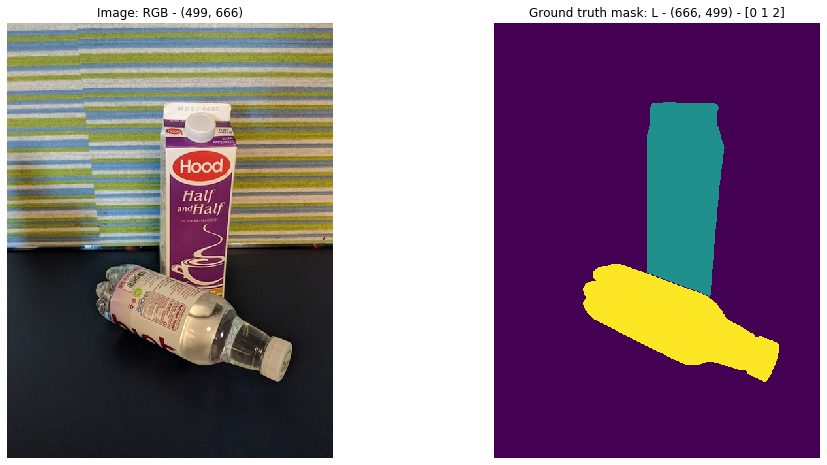

In [5]:
# view the 18th image and its mask
im = Image.open(im_path)
mask = Image.open(mask_path)
mask_np = np.array(mask)
im_label = f'Image: {im.mode} - {im.size}'
mask_label = f'Ground truth mask: {mask.mode} - {mask_np.shape} - {np.unique(mask_np)}'

show_ims([im_path, mask_path], [im_label, mask_label], size=8)

## Instance Segmentation with Pretrained Mask R-CNN Model

We will use the pretrained [Mask R-CNN ResNet-50 FPN](https://pytorch.org/docs/stable/torchvision/models.html#mask-r-cnn) in PyTorch for instance segmentation.  As described on [this torchvision page](https://pytorch.org/docs/stable/torchvision/models.html#mask-r-cnn), the model is pretrained on [COCO train2017](http://images.cocodataset.org/zips/train2017.zip) (18GB).  It expects a list of images as `List[Tensor[C, H, W]]` in the range of `0-1` and returns the predictions as `List[Dict[Tensor]]`.  The fields of the `Dict` include `scores`, `labels`, `boxes` and `masks`, each of which is of the same length as the input image list.  The `labels` belong to the 91 categories in the [COCO datasets](http://cocodataset.org/).

Similar to [01_training_introduction notebook](01_training_introduction.ipynb), we can use `get_pretrained_maskrcnn()` to get the pretrained Mask R-CNN model to create a `DetectionLearner`.

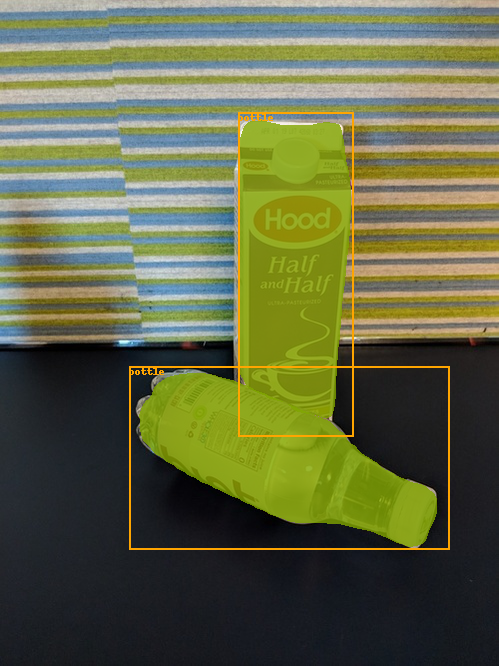

In [6]:
# get pretrained model
detector = DetectionLearner(
    model=get_pretrained_maskrcnn(), 
    device=device,
    labels=coco_labels()[1:],
)
# predict
detections = detector.predict(im_path, threshold=THRESHOLD)

# plot
plot_detections(detections)

The model detected the unexpeced "dining table" and mistaken the "carton" as a "book".  That is because the [COCO](http://cocodataset.org/) has a class called "dining table" and does not include the class "carton".

## Finetuning Mask R-CNN model

Since there are no "carton", "milk bottle" and "water bottle" in the labels of COCO datasets, we need to fine-tune the pre-trained Mask R-CNN model for odFridgeObjects-mask with the 4 labels and get rid of the other unexpected categories, such as "dining table".  Following the practice in our [01_training_introduction notebook](01_training_introduction.ipynb), we need to prepare the `DetectionDataset` to be used by the `DetectionLearner` with a customized Mask R-CNN model.  To prepare a custom dataset, there should be a separate directory containing the masks demontrated in the above.

### Prepare Dataset and Load Images

To load the data, we need to create a Dataset object class that Torchvision knows how to use.  To make it more convinient, we've created a DetectionDataset class that knows how to extract annotation information from the Pascal VOC format and meet the requirements of the Torchvision dataset object class.  There is an additional parameter `mask_dir` for specifying the mask directory.

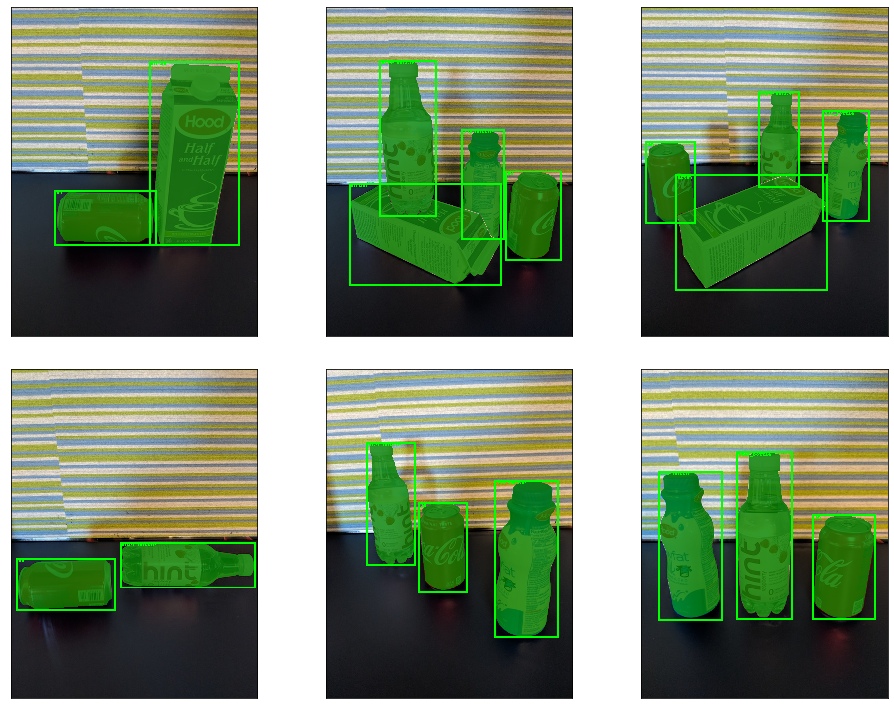

In [7]:
mask_data = DetectionDataset(root=DATA_PATH, mask_dir='segmentation-masks')
mask_data.show_ims(rows=2, seed=168)

### Re-train

We provide the `get_pretrained_maskrcnn()` function to facilitate the customization of Mask R-CNN model with a ResNet-50-FPN backbone.

In [ ]:
# train
detector = DetectionLearner(
    dataset=mask_data,
    model=get_pretrained_maskrcnn(len(mask_data.labels)+1),
    device=device)
detector.fit(epochs=EPOCHS, lr=0.005, print_freq=30)

Visualize the loss and average precision (ap) over time.

In [ ]:
detector.plot_precision_loss_curves()

We can simply run the evaluate() method on our detector to evaluate the results.

In [ ]:
e = detector.evaluate()

Plot precision-recall curves.  There are two sets of subplots, one for bounding box, the other for mask.

In [ ]:
plot_pr_curves(e)

### Predict Single Image

Using the re-trained model, we can predict again.

Found 2 objects with confidence above the threshold.


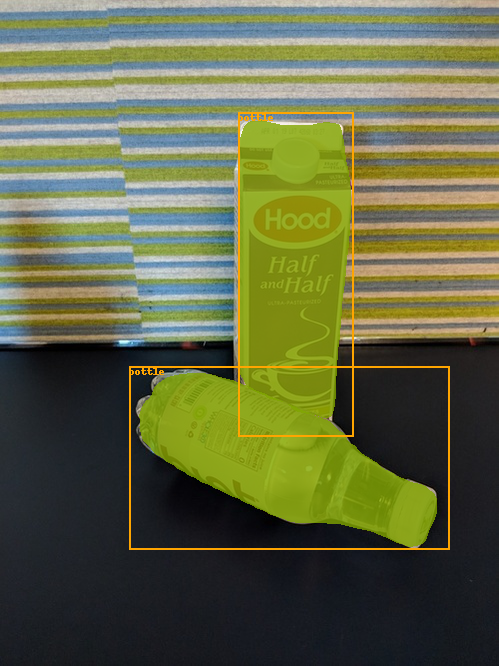

In [9]:
# predict
idx = 18
detections = detector.predict(mask_data.im_paths[idx], threshold=THRESHOLD)
print(f"Found {len(detections['det_bboxes'])} objects with confidence above the threshold.")

# plot
plot_detections(detections)

Now we have `milk_bottle` and `can` in the labels of the model.  However, because there are only 31 images annotated with masks, this result is not ideal.

In [ ]:
# preserve some of the notebook outputs
sb.glue("training_losses", detector.losses)
sb.glue("training_average_precision", detector.ap)

## Conclusion

In this notebook, we demonstrate how to use the concepts in our [01_training_introduction notebook](01_training_introduction.ipynb) to prepare an Mask R-CNN model detector fine-tuned on your own dataset for instance segmentation.